## Introduction

This notebook is dedicated to the development of the classification model for classifying loan applications into accepted or rejected. The model is developed using the data from the previous notebook, which was cleaned and preprocessed.

## Importing necessary libraries

In [80]:
from lightgbm import LGBMClassifier

import functions as f
import pandas as pd
import numpy as np

from functions import CustomOrdinalEncoder, CustomWordExtractor, CustomCategoricalConverter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.selection import DropCorrelatedFeatures, DropFeatures
from feature_engine.encoding import OrdinalEncoder
from sklearn.metrics import classification_report

import shap
shap.initjs()

from skopt import BayesSearchCV

import pickle

## Importing Train and Test sets from EDA Notebook

In [81]:
train_set = pd.read_csv("/Users/laurynas/Documents/DataScience/Projects/Data/lending-club/train_set_df_1.csv", low_memory=False)
test_set = pd.read_csv("/Users/laurynas/Documents/DataScience/Projects/Data/lending-club/test_set_df_1.csv", low_memory=False)

In [82]:
X_train = train_set.drop("policy_code", axis=1)
y_train = train_set["policy_code"]

In [83]:
X_train.dtypes

amount_requested        float64
loan_title               object
risk_score              float64
debt_to_income_ratio    float64
zip_code                 object
state                    object
employment_length        object
dtype: object

## Building the Pipeline

In [84]:
order = [
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]
cat_feat = ["zip_code", "state"]

custom_word_pipeline = Pipeline(
    steps=[
        ("word_extractor", CustomWordExtractor(column_name="loan_title")),
        ("ordinal_encoder", OrdinalEncoder(
                encoding_method="arbitrary", missing_values="ignore", unseen="encode"
            ))
    ]
)
preprocess_pipeline = ColumnTransformer(
    transformers=[
        ("custom_ordinal_encoder", CustomOrdinalEncoder(column_name="employment_length", order=order), ["employment_length"]),
        ("custom_word_pipeline", custom_word_pipeline, ["loan_title"]),
        ("cat_encoding", OrdinalEncoder(
                encoding_method="arbitrary", missing_values="ignore", unseen="encode"), cat_feat),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)
preprocess_pipeline.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('custom_ordinal_encoder',
                                 CustomOrdinalEncoder(column_name='employment_length',
                                                      order=['< 1 year',
                                                             '1 year',
                                                             '2 years',
                                                             '3 years',
                                                             '4 years',
                                                             '5 years',
                                                             '6 years',
                                                             '7 years',
                                                             '8 years',
                                                             '9 years',
                                                             '10+ years']),
                                 ['employment_length']),
                                ('custom_word_pipeline',
                                 Pipeline(steps=[('word_extractor',
                                                  CustomWordExtractor(column_name='loan_title')),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(encoding_method='arbitrary',
                                                                 missing_values='ignore',
                                                                 unseen='encode'))]),
                                 ['loan_title']),
                                ('cat_encoding',
                                 OrdinalEncoder(encoding_method='arbitrary',
                                                missing_values='ignore',
                                                unseen='encode'),
                                 ['zip_code', 'state'])],
                  verbose_feature_names_out=False)

In [85]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True, random_state=42)

In [86]:
cat_features = [
    "loan_title",
    "zip_code",
    "state",
    "employment_length"
]
pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_pipeline),
        ("convert_to_categorical", CustomCategoricalConverter(columns_to_convert=cat_features))
    ]
)
X_train_transformed = pipeline.fit_transform(X_train)
X_valid_transformed = pipeline.transform(X_valid)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


MODEL EVALUATION ON TRAINING SET


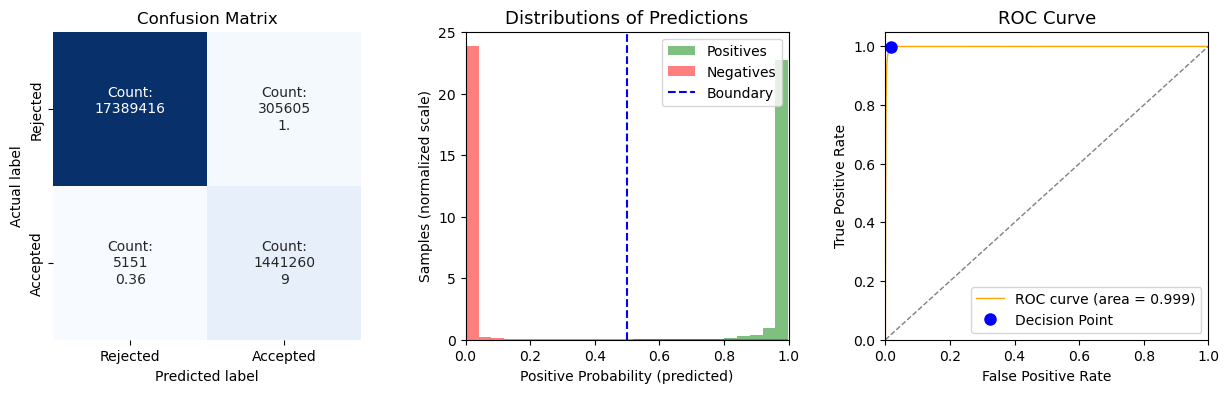

Precision: 0.825 | Recall: 0.996 | F1 Score: 0.903 | AUC: 0.999
------------------------------------------------------------------
MODEL EVALUATION ON VALIDATION SET


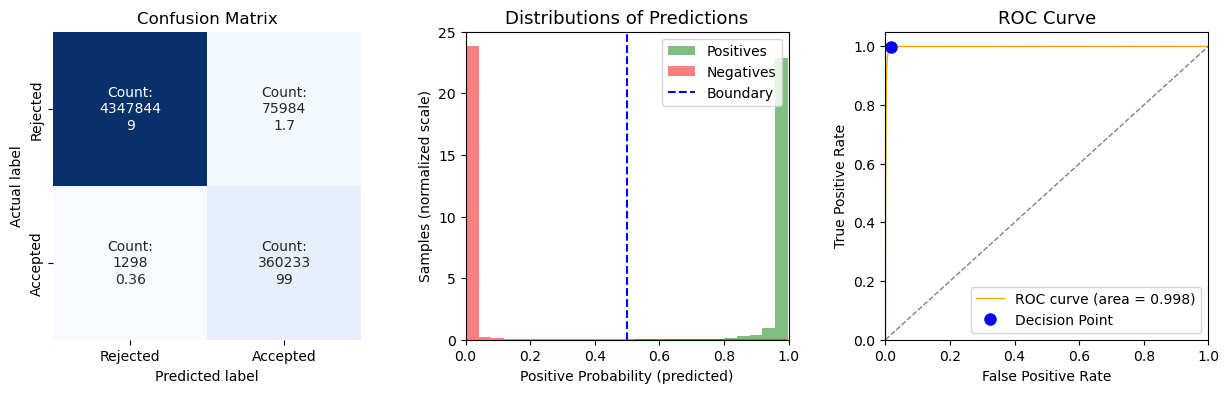

Precision: 0.826 | Recall: 0.996 | F1 Score: 0.903 | AUC: 0.998
------------------------------------------------------------------


In [87]:
weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

classifier = LGBMClassifier(random_state=1, n_jobs=-1, scale_pos_weight=weight, objective="binary")

classifier.fit(X_train_transformed, y_train, early_stopping_rounds = 10, eval_set = [(X_valid_transformed, y_valid)], verbose=-1)
print("MODEL EVALUATION ON TRAINING SET")
y_pred = classifier.predict_proba(X_train_transformed)
f.binary_performances(y_train, y_pred, categories=["Rejected", "Accepted"])
print("------------------------------------------------------------------")
print("MODEL EVALUATION ON VALIDATION SET")
y_pred = classifier.predict_proba(X_valid_transformed)
f.binary_performances(y_valid, y_pred, categories=["Rejected", "Accepted"])
print("------------------------------------------------------------------")

<Axes: >

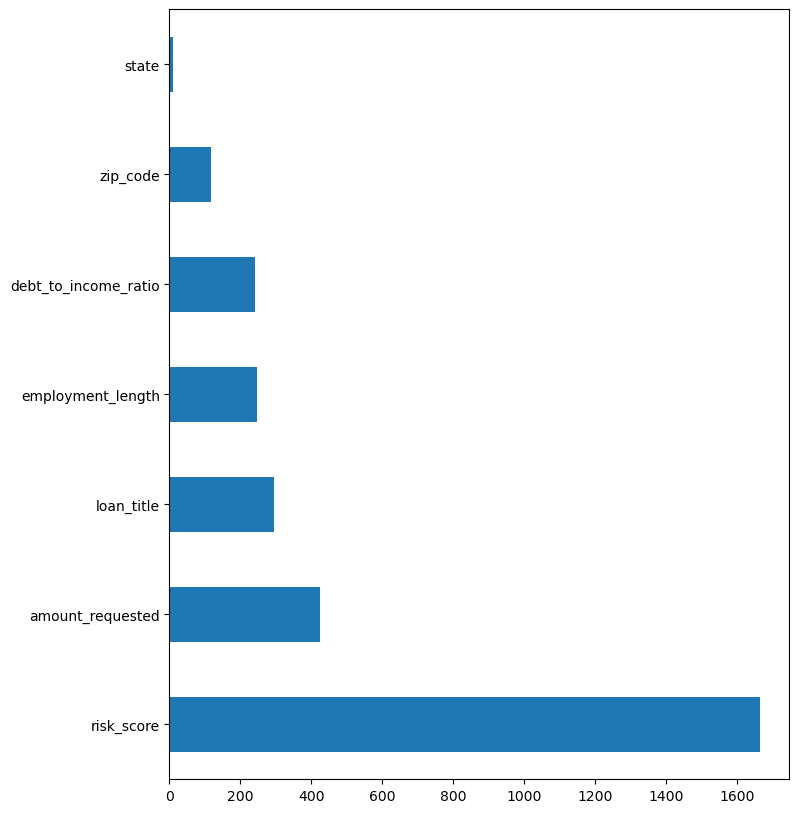

In [88]:
feat_imp = pd.Series(classifier.feature_importances_, index=X_train_transformed.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


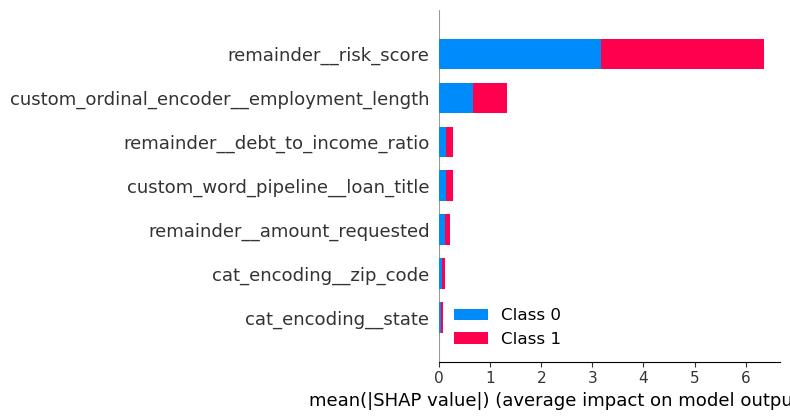

In [12]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_train_transformed)
shap.summary_plot(shap_values, X_train_transformed)

In [89]:
selected_features = [
    "risk_score",
    "employment_length",
    "debt_to_income_ratio",
    "loan_title",
    "amount_requested",
]
features_to_drop = list(set(X_train_transformed.columns) - set(selected_features))
X_train_transformed.drop(features_to_drop, axis=1, inplace=True)
X_valid_transformed.drop(features_to_drop, axis=1, inplace=True)

In [ ]:
param_space = {
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'num_iterations': (50, 500),
    'num_leaves': (150, 250),
    'max_bin': (400, 700),
    'min_data_in_leaf': (20, 50),
    'early_stopping_rounds': (10, 30),
}
opt = BayesSearchCV(
    classifier,
    param_space,
    n_iter=20,
    scoring='accuracy',
    n_jobs=-1,
    cv=3,
    verbose=0
)
opt.fit(X_train_transformed, y_train, eval_set = [(X_valid_transformed, y_valid)])

In [18]:
opt.best_params_

OrderedDict([('early_stopping_rounds', 30),
             ('learning_rate', 0.1),
             ('max_bin', 535),
             ('min_data_in_leaf', 29),
             ('num_iterations', 409),
             ('num_leaves', 250)])

In [91]:
best_params = {
    "early_stopping_rounds": 30,
    "learning_rate": 0.1,
    "max_bin": 535,
    "min_data_in_leaf": 29,
    "num_iterations": 409,
    "num_leaves": 250,
}
X_train.drop(features_to_drop, axis=1, inplace=True)

In [104]:
custom_word_pipeline = Pipeline(
    steps=[
        ("word_extractor", CustomWordExtractor(column_name="loan_title")),
        ("ordinal_encoder", OrdinalEncoder(
                encoding_method="arbitrary", missing_values="ignore", unseen="encode"
            ))
    ]
)
pre_pipeline = ColumnTransformer(
    transformers=[
        ("word_extractor", custom_word_pipeline, ["loan_title"]),
        ("custom_ordinal_encoder", CustomOrdinalEncoder(column_name="employment_length", order=order), ["employment_length"]),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)
pre_pipeline.set_output(transform="pandas")
final_pipeline = Pipeline(
    steps=[
        ("preprocess", pre_pipeline),
        ("convert_to_categorical", CustomCategoricalConverter(columns_to_convert=["loan_title", "employment_length"])),
        ("classifier", LGBMClassifier(random_state=1, n_jobs=-1, scale_pos_weight=weight, objective="binary", **best_params)),
    ]
)
final_pipeline.fit(X_train, y_train, classifier__eval_set = [(X_valid_transformed, y_valid)], classifier__verbose=-1)


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('word_extractor',
                                                  Pipeline(steps=[('word_extractor',
                                                                   CustomWordExtractor(column_name='loan_title')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder(encoding_method='arbitrary',
                                                                                  missing_values='ignore',
                                                                                  unseen='encode'))]),
                                                  ['loan_title']),
                                                 ('custom_ordinal_encoder',
                                                  CustomOrdinalEnco...
                                                  ['employment_length'])],
                                   verbose_feature_names_out=False)),
                ('convert_to_categorical',
                 CustomCategoricalConverter(columns_to_convert=['loan_title',
                                                                'employment_length'])),
                ('classifier',
                 LGBMClassifier(early_stopping_rounds=30, max_bin=535,
                                min_data_in_leaf=29, num_iterations=409,
                                num_leaves=250, objective='binary',
                                random_state=1,
                                scale_pos_weight=12.233743382759119))])

MODEL EVALUATION ON VALIDATION SET


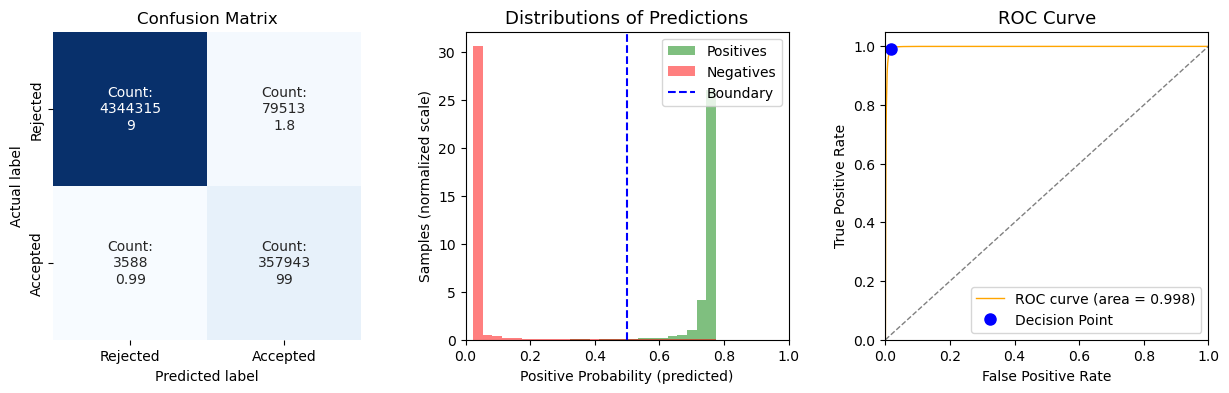

Precision: 0.818 | Recall: 0.99 | F1 Score: 0.896 | AUC: 0.998


{'Precision': 0.8182377199078308,
 'Recall': 0.9900755398568865,
 'F1 Score': 0.8959920499332279,
 'AUC': 0.9977208492056195}

In [105]:
print("MODEL EVALUATION ON VALIDATION SET")
y_pred = final_pipeline.predict_proba(X_valid)
f.binary_performances(y_valid, y_pred, categories=["Rejected", "Accepted"])

## Final evaluation on Test set

In [106]:
X_test = test_set.drop("policy_code", axis=1)
y_test = test_set["policy_code"]
X_test.drop(features_to_drop, axis=1, inplace=True)

MODEL EVALUATION ON TEST SET


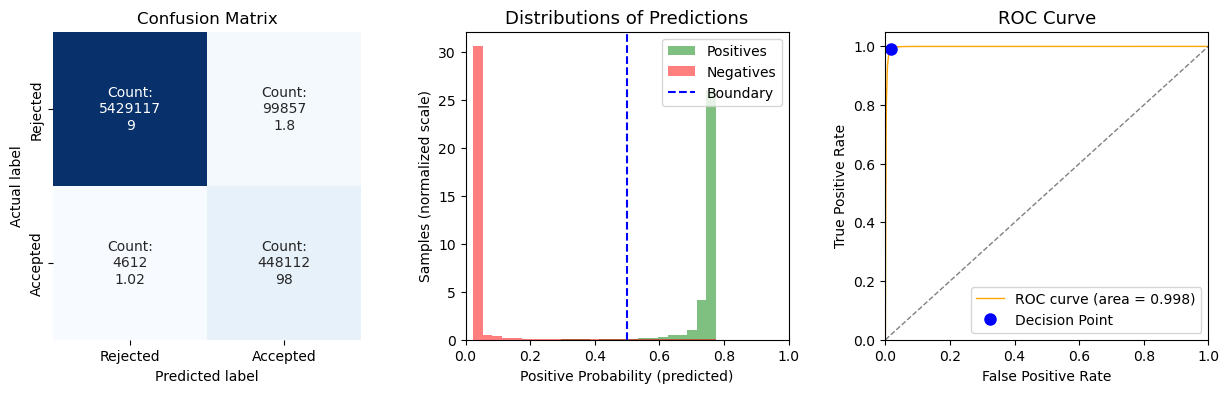

Precision: 0.818 | Recall: 0.99 | F1 Score: 0.896 | AUC: 0.998


{'Precision': 0.8177688883860218,
 'Recall': 0.9898127777630521,
 'F1 Score': 0.8956033468806117,
 'AUC': 0.9976884892187631}

In [107]:
print("MODEL EVALUATION ON TEST SET")
y_pred = final_pipeline.predict_proba(X_test)
f.binary_performances(y_test, y_pred, categories=["Rejected", "Accepted"])

In [108]:
final_pipeline.score(X_test, y_test)

0.9825352266195987

## Saving the final model

In [109]:
# with open("application_model-0.1.0.pkl", "wb") as f:
#     pickle.dump(final_pipeline, f)